In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt

%matplotlib inline
warnings.simplefilter("ignore")

На этой неделе предстоит поучаствовать в соревновании на kaggle inclass  
Ссылка на страницу соревнования: 
https://inclass.kaggle.com/c/telecom-clients-prediction2

In [2]:
train = pd.read_csv("train.csv", index_col=0)

train = train.reset_index(drop=True)
x_numeric = train.columns[:190]
x_cat = train.columns[190:-1]

useless_train = train.iloc[:, :-1].describe().loc["count", :] 
x_numeric = [x for x in x_numeric if x not in useless_train[useless_train == 0].index]
x_cat = [x for x in x_cat if x not in useless_train[useless_train == 0].index]
train.drop(columns=useless_train[useless_train == 0].index, inplace=True)

X = train.iloc[:, :-1]
y = (train.iloc[:, -1] == 1)* 1

In [3]:
X[x_cat] = X[x_cat].fillna("unknown")
fillna_val = X[x_numeric].mean()
X[x_numeric] = X[x_numeric].fillna(fillna_val)

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), x_numeric),
        ('cat', OneHotEncoder(handle_unknown="ignore"), x_cat)])

In [5]:
def get_result_pipl(pipl, X=X, y=y):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    f1_list = []
    auc_list = []
    prec_list = []
    recall_list = []
    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        pipl.fit(X.loc[train_index, :], y.loc[train_index])
        y_pred = pipl.predict_proba(X.loc[test_index, :])[:, pipl.classes_ == 1]
        auc_list.append(roc_auc_score(y.loc[test_index], y_pred))
    return auc_list

In [6]:
res = {}

На прошлой неделе мы пришли к выводу, что градиентный бустинг работал успешнее других, поэтому воспользуемся им.

In [7]:
pipl_xgb = Pipeline([('preprocessor', preprocessor), ('clf', GradientBoostingClassifier())])
res['xgb'] = get_result_pipl(pipl_xgb, X=X, y=y)

TRAIN: [    0     3     4 ... 35997 35998 35999] TEST: [    1     2     7 ... 35982 35991 35994]
TRAIN: [    0     1     2 ... 35996 35997 35999] TEST: [   10    19    24 ... 35986 35995 35998]
TRAIN: [    0     1     2 ... 35996 35998 35999] TEST: [    3     4     5 ... 35992 35993 35997]
TRAIN: [    1     2     3 ... 35996 35997 35998] TEST: [    0     6    12 ... 35981 35988 35999]
TRAIN: [    0     1     2 ... 35997 35998 35999] TEST: [   11    15    17 ... 35987 35990 35996]


In [8]:
pipl = pipl_xgb
pipl.fit(X, y)

test = pd.read_csv("orange_small_churn_test_data.csv", index_col=0)
test = test[x_cat + x_numeric]
test[x_cat] = test[x_cat].fillna("unknown")
test[x_numeric] = test[x_numeric].fillna(fillna_val)
y_pred = pipl.predict_proba(test)[:, pipl.classes_ == 1]

test["result"] = y_pred
test["result"].reset_index().rename({"ID": "Id"}, axis=1).to_csv("test.csv", index=False)

In [9]:
test["result"]

ID
0       0.051520
1       0.091213
2       0.024944
3       0.081626
4       0.025664
          ...   
9995    0.038033
9996    0.045813
9997    0.051472
9998    0.032994
9999    0.058115
Name: result, Length: 10000, dtype: float64

In [10]:
test["result"].to_csv('result_.csv') 

Прикрепляю свои результаты с kaggle

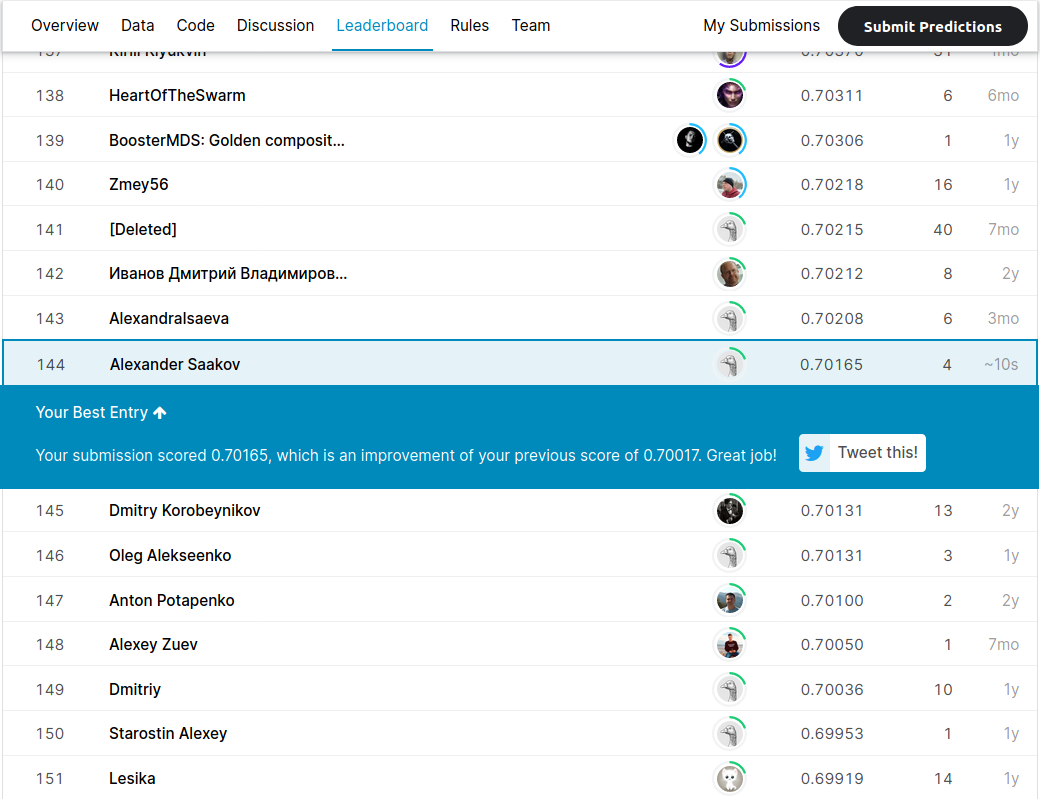

In [12]:
from IPython.display import Image
Image(filename='kaggle1.png')